*Yigao Li*  
*Nov 15, 2018*

In [1]:
## packages for this assignment
from keras.datasets import fashion_mnist
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, GRU, Embedding, Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import requests
import matplotlib.pyplot as plt
import cv2

Using TensorFlow backend.


# Autoencoder

In [0]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# data normalization
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = 645)
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test = to_categorical(y_test, 10)
batch_size = 64
epochs = 3
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [0]:
def encoder(input_img):
    # input 28*28*1
    conv1 = Conv2D(16, (3, 3), activation = "relu", padding = "same")(input_img) #28*28*32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation = "relu", padding = "same")(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1) #14*14*32
    conv2 = Conv2D(8, (3, 3), activation = "relu", padding = "same")(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(8, (3, 3), activation = "relu", padding = "same")(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2) #7*7*64
    conv3 = Conv2D(4, (3, 3), activation = "relu", padding = "same")(pool2) #7*7*128
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(4, (3, 3), activation = "relu", padding = "same")(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(2, (3, 3), activation = "relu", padding = "same")(conv3) #7*7*256
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(2, (3, 3), activation = "relu", padding = "same")(conv4)
    representation = BatchNormalization()(conv4)
    return representation
    
def decoder(compressed):
    conv5 = Conv2D(4, (3, 3), activation = "relu", padding = "same")(compressed) #7*7*128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(4, (3, 3), activation = "relu", padding = "same")(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(8, (3, 3), activation = "relu", padding = "same")(conv5) #7*7*64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(8, (3, 3), activation = "relu", padding = "same")(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D(size = (2, 2))(conv6) #14*14*64
    conv7 = Conv2D(16, (3, 3), activation = "relu", padding = "same")(up1)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(16, (3, 3), activation = "relu", padding = "same")(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D(size = (2, 2))(conv7) #28*28*32
    reconstruction = Conv2D(1, (3, 3), activation = "sigmoid", padding = "same")(up2) #28*28*1
    return reconstruction

autoencoder_conv = Model(input_img, decoder(encoder(input_img)))
autoencoder_conv.compile(loss = "mean_squared_error", optimizer = "adadelta")
autoencoder_conv.fit(x_train, x_train, epochs = epochs, batch_size = batch_size, validation_data = (x_valid, x_valid))

Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 258s 5ms/step - loss: 0.0447 - val_loss: 0.0288
Epoch 2/3
48000/48000 [==============================] - 254s 5ms/step - loss: 0.0256 - val_loss: 0.0240
Epoch 3/3
48000/48000 [==============================] - 254s 5ms/step - loss: 0.0219 - val_loss: 0.0199


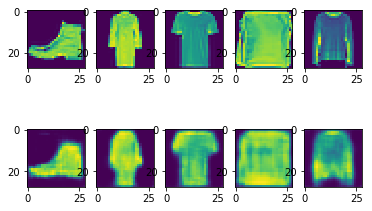

In [0]:
num_list = [45686, 13291, 47724, 26419, 35937]
for i in range(len(num_list)):
    k = num_list[i]
    ax = plt.subplot(2, len(num_list), i+1)
    plt.imshow(x_train[k:k+1,:].reshape((28,28)))
    ax = plt.subplot(2, len(num_list), i+1+len(num_list))
    reconstruction = autoencoder_conv.predict(x_train[k:k+1,:])
    reconstruction.resize((28,28))
    plt.imshow(reconstruction)
plt.show()

# Image Classification

## Deep CNN

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = "relu", padding = "valid", input_shape = (28, 28, 1))) #strides=1 by default
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = "relu", padding = "valid"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = "relu", padding = "valid"))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(num_classes, activation = "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer = "adadelta", metrics = ["accuracy"])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               147584    
__________

In [0]:
train_model = model.fit(x_train, y_train, epochs = 10, batch_size = batch_size, verbose = 1, validation_data = (x_valid, y_valid))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 43s 895us/step - loss: 0.4247 - acc: 0.8437 - val_loss: 0.3764 - val_acc: 0.8598
Epoch 2/10
48000/48000 [==============================] - 45s 930us/step - loss: 0.3230 - acc: 0.8812 - val_loss: 0.3170 - val_acc: 0.8872
Epoch 3/10
48000/48000 [==============================] - 36s 759us/step - loss: 0.2808 - acc: 0.8957 - val_loss: 0.2939 - val_acc: 0.8918
Epoch 4/10
48000/48000 [==============================] - 36s 755us/step - loss: 0.2473 - acc: 0.9072 - val_loss: 0.3001 - val_acc: 0.8904
Epoch 5/10
48000/48000 [==============================] - 36s 755us/step - loss: 0.2229 - acc: 0.9170 - val_loss: 0.2650 - val_acc: 0.9038
Epoch 6/10
48000/48000 [==============================] - 36s 757us/step - loss: 0.2002 - acc: 0.9251 - val_loss: 0.2663 - val_acc: 0.9032
Epoch 7/10
48000/48000 [==============================] - 36s 758us/step - loss: 0.1797 - acc: 0.9327 - val_loss: 0.

In [0]:
score = model.evaluate(x_test, y_test, verbose = 0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.2765565358430147
Test accuracy: 0.9097


Training accuracy is $95.09\%$. Validation accuracy is $91.63\%$. Test accuracy is $90.97\%$.

## Transfer Learning

In [0]:
x_train = np.asarray([cv2.resize(x, (32,32)) for x in x_train])
x_valid = np.asarray([cv2.resize(x, (32,32)) for x in x_valid])
x_test = np.asarray([cv2.resize(x, (32,32)) for x in x_test])
x_train = x_train.reshape(x_train.shape[0], 32, 32, 1)
x_valid = x_valid.reshape(x_valid.shape[0], 32, 32, 1)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 1)
x_train = x_train.repeat(3, axis = -1)
x_valid = x_valid.repeat(3, axis = -1)
x_test = x_test.repeat(3, axis = -1)

In [4]:
conv_base = VGG16(weights = "imagenet", include_top = False, input_shape = (32, 32, 3))
model_tl = Sequential()
model_tl.add(conv_base)
model_tl.add(Flatten())
model_tl.add(Dense(512, activation = "relu"))
model_tl.add(Dense(num_classes, activation = "softmax"))
conv_base.trainable = False
model_tl.trainable_weights

[<tf.Variable 'dense_1/kernel:0' shape=(512, 512) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(512, 10) dtype=float32_ref>,
 <tf.Variable 'dense_2/bias:0' shape=(10,) dtype=float32_ref>]

In [5]:
model_tl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 267,786
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
model_tl.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["acc"])

In [7]:
model_tl.fit(x_train, y_train, batch_size = batch_size, epochs = 10, validation_data = (x_valid, y_valid))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 675s 14ms/step - loss: 0.5418 - acc: 0.8072 - val_loss: 0.4400 - val_acc: 0.8431
Epoch 2/10
48000/48000 [==============================] - 675s 14ms/step - loss: 0.4062 - acc: 0.8498 - val_loss: 0.4236 - val_acc: 0.8492
Epoch 3/10
48000/48000 [==============================] - 671s 14ms/step - loss: 0.3710 - acc: 0.8620 - val_loss: 0.3956 - val_acc: 0.8566
Epoch 4/10
48000/48000 [==============================] - 671s 14ms/step - loss: 0.3500 - acc: 0.8688 - val_loss: 0.4082 - val_acc: 0.8506
Epoch 5/10
48000/48000 [==============================] - 671s 14ms/step - loss: 0.3268 - acc: 0.8780 - val_loss: 0.3781 - val_acc: 0.8643
Epoch 6/10
48000/48000 [==============================] - 674s 14ms/step - loss: 0.3102 - acc: 0.8837 - val_loss: 0.3629 - val_acc: 0.8688
Epoch 7/10
48000/48000 [==============================] - 676s 14ms/step - loss: 0.2976 - acc: 0.8895 - val_loss: 0.

In [8]:
score_tl = model_tl.evaluate(x_test, y_test, verbose = 0)
print("Test loss:", score_tl[0])
print("Test accuracy:", score_tl[1])

Test loss: 0.3805254009723663
Test accuracy: 0.8668


# Text Classification

## RNN

Here we use Gated Recurrent Unit (GRU) in our RNN.

In [0]:
url_b = requests.get("https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt").text.split("\n")
url_m = requests.get("https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt").text.split("\n")
url_b = [x for x in url_b if x[0] != "#"]
X_train = np.asarray(url_b + url_m)
Y_train = np.concatenate((np.ones(len(url_b)), np.zeros(len(url_m))))
print(len(url_b))
print(len(url_m))
tokenizer = Tokenizer(char_level = True)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train, mode = "count")
print(X_train.shape)
maxlen = X_train.shape[1]

66015
1297
(67312, 42)


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.5, random_state = 9921)

In [0]:
model_text_rnn = Sequential()
model_text_rnn.add(Embedding(input_dim = 100, output_dim = 32, input_length = maxlen))
model_text_rnn.add(GRU(32))
model_text_rnn.add(Dense(1, activation = "sigmoid"))
model_text_rnn.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["acc"])

In [0]:
model_text_rnn.fit(X_train, Y_train, epochs = 10, batch_size = 64, validation_data = (X_test, Y_test), verbose = 1)

Train on 33656 samples, validate on 33656 samples
Epoch 1/10
33656/33656 [==============================] - 13s 380us/step - loss: 0.1169 - acc: 0.9808 - val_loss: 0.0682 - val_acc: 0.9806
Epoch 2/10
33656/33656 [==============================] - 11s 335us/step - loss: 0.0584 - acc: 0.9808 - val_loss: 0.0564 - val_acc: 0.9806
Epoch 3/10
33656/33656 [==============================] - 10s 302us/step - loss: 0.0571 - acc: 0.9808 - val_loss: 0.0567 - val_acc: 0.9806
Epoch 4/10
33656/33656 [==============================] - 10s 308us/step - loss: 0.0571 - acc: 0.9808 - val_loss: 0.0567 - val_acc: 0.9806
Epoch 5/10
33656/33656 [==============================] - 10s 306us/step - loss: 0.0567 - acc: 0.9808 - val_loss: 0.0555 - val_acc: 0.9806
Epoch 6/10
33656/33656 [==============================] - 10s 309us/step - loss: 0.0560 - acc: 0.9808 - val_loss: 0.0557 - val_acc: 0.9806
Epoch 7/10
33656/33656 [==============================] - 11s 313us/step - loss: 0.0561 - acc: 0.9808 - val_loss: 0.

In [0]:
score_rnn = model_text_rnn.evaluate(X_test, Y_test, verbose = 0)
print("Test loss:", score_rnn[0])
print("Test accuracy:", score_rnn[1])

Test loss: 0.054143391998258045
Test accuracy: 0.9807463750891372


## CNN

In [0]:
model_text_cnn = Sequential()
model_text_cnn.add(Embedding(input_dim = 100, output_dim = 32, input_length = maxlen))
model_text_cnn.add(Conv1D(256, 3, activation = "relu"))
model_text_cnn.add(MaxPooling1D(3))
model_text_cnn.add(Flatten())
model_text_cnn.add(Dense(256, activation = "relu"))
model_text_cnn.add(Dense(1, activation = "sigmoid"))
model_text_cnn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["acc"])

In [0]:
model_text_cnn.fit(X_train, Y_train, batch_size = 64, epochs = 10, validation_data = (X_test, Y_test))

Train on 33656 samples, validate on 33656 samples
Epoch 1/10
33656/33656 [==============================] - 21s 633us/step - loss: 0.0609 - acc: 0.9798 - val_loss: 0.0399 - val_acc: 0.9843
Epoch 2/10
33656/33656 [==============================] - 20s 606us/step - loss: 0.0359 - acc: 0.9856 - val_loss: 0.0360 - val_acc: 0.9847
Epoch 3/10
33656/33656 [==============================] - 21s 614us/step - loss: 0.0332 - acc: 0.9867 - val_loss: 0.0340 - val_acc: 0.9857
Epoch 4/10
33656/33656 [==============================] - 21s 615us/step - loss: 0.0308 - acc: 0.9875 - val_loss: 0.0325 - val_acc: 0.9859
Epoch 5/10
33656/33656 [==============================] - 21s 629us/step - loss: 0.0294 - acc: 0.9886 - val_loss: 0.0337 - val_acc: 0.9852
Epoch 6/10
33656/33656 [==============================] - 21s 620us/step - loss: 0.0274 - acc: 0.9888 - val_loss: 0.0324 - val_acc: 0.9865
Epoch 7/10
33656/33656 [==============================] - 21s 617us/step - loss: 0.0257 - acc: 0.9890 - val_loss: 0.

In [0]:
score_cnn = model_text_cnn.evaluate(X_test, Y_test, verbose = 0)
print("Test loss:", score_cnn[0])
print("Test accuracy:", score_cnn[1])

Test loss: 0.04054971090232607
Test accuracy: 0.9847278345614452


## Compare RNN & CNN

In [0]:
Y_rnn = model_text_rnn.predict(X_test).ravel()
Y_cnn = model_text_cnn.predict(X_test).ravel()
fpr_r, tpr_r, thresholds_r = roc_curve(Y_test, Y_rnn)
auc_r = auc(fpr_r, tpr_r)
fpr_c, tpr_c, thresholds_c = roc_curve(Y_test, Y_cnn)
auc_c = auc(fpr_c, tpr_c)

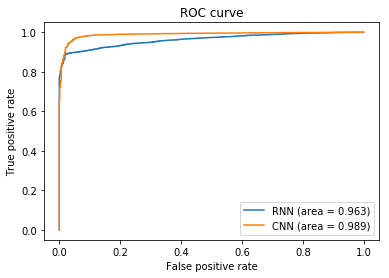

In [0]:
plt.figure(1)
plt.plot(fpr_r, tpr_r, label='RNN (area = {:.3f})'.format(auc_r))
plt.plot(fpr_c, tpr_c, label='CNN (area = {:.3f})'.format(auc_c))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()